In [12]:
import os
import math
from typing import List, Dict

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPModel, CLIPProcessor
from torch.nn.functional import cosine_similarity

In [10]:
import torch

def load_lora_weights(model, path):
    lora_state = torch.load(path, map_location="cpu")

    for name, module in model.named_modules():
        if isinstance(module, LoRALinear) and name in lora_state:
            module.lora_A.load_state_dict(lora_state[name]["lora_A"])
            module.lora_B.load_state_dict(lora_state[name]["lora_B"])

    print("Loaded LoRA weights from", path)


In [13]:
class LoRALinear(nn.Module):
    """
    LoRA wrapper around a Linear layer:
      y = x W^T + (alpha/r) * B(A(x))
    where A: in -> r, B: r -> out.
    """
    def __init__(self, base_layer: nn.Linear, r: int = 8, alpha: float = 16.0):
        super().__init__()
        self.in_features = base_layer.in_features
        self.out_features = base_layer.out_features
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r

        # Original (frozen) weight & bias
        self.weight = base_layer.weight
        self.bias = base_layer.bias

        # LoRA trainable weights
        self.lora_A = nn.Linear(self.in_features, r, bias=False)
        self.lora_B = nn.Linear(r, self.out_features, bias=False)

        # Init LoRA
        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)

        # Freeze original
        self.weight.requires_grad = False
        if self.bias is not None:
            self.bias.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        base = F.linear(x, self.weight, self.bias)
        lora_out = self.lora_B(self.lora_A(x)) * self.scaling
        return base + lora_out

    def state_dict(self, *args, **kwargs):
        return {
            "lora_A": self.lora_A.state_dict(),
            "lora_B": self.lora_B.state_dict(),
        }
    
    def load_state_dict(self, sd):
        self.lora_A.load_state_dict(sd["lora_A"])
        self.lora_B.load_state_dict(sd["lora_B"])


In [14]:
def apply_lora_to_clip_attn(model: nn.Module, r: int = 8, alpha: float = 16.0):
    """
    Replace all q_proj and v_proj Linear layers in CLIP with LoRALinear.
    """
    for module_name, module in model.named_modules():
        for child_name, child in list(module.named_children()):
            if isinstance(child, nn.Linear) and child_name in ["q_proj", "v_proj"]:
                lora_layer = LoRALinear(child, r=r, alpha=alpha)
                setattr(module, child_name, lora_layer)

In [15]:
apply_lora_to_clip_attn(model, r=8, alpha=16)

In [16]:
from transformers import CLIPModel, CLIPProcessor
model = CLIPModel.from_pretrained("./clip_finetuned_demo")
processor = CLIPProcessor.from_pretrained("./clip_finetuned_demo")
load_lora_weights(model, "lora_weight.pt")

Some weights of the model checkpoint at ./clip_finetuned_demo were not used when initializing CLIPModel: ['text_model.encoder.layers.0.self_attn.q_proj.lora_A.weight', 'text_model.encoder.layers.0.self_attn.q_proj.lora_B.weight', 'text_model.encoder.layers.0.self_attn.v_proj.lora_A.weight', 'text_model.encoder.layers.0.self_attn.v_proj.lora_B.weight', 'text_model.encoder.layers.1.self_attn.q_proj.lora_A.weight', 'text_model.encoder.layers.1.self_attn.q_proj.lora_B.weight', 'text_model.encoder.layers.1.self_attn.v_proj.lora_A.weight', 'text_model.encoder.layers.1.self_attn.v_proj.lora_B.weight', 'text_model.encoder.layers.10.self_attn.q_proj.lora_A.weight', 'text_model.encoder.layers.10.self_attn.q_proj.lora_B.weight', 'text_model.encoder.layers.10.self_attn.v_proj.lora_A.weight', 'text_model.encoder.layers.10.self_attn.v_proj.lora_B.weight', 'text_model.encoder.layers.11.self_attn.q_proj.lora_A.weight', 'text_model.encoder.layers.11.self_attn.q_proj.lora_B.weight', 'text_model.encoder.

Loaded LoRA weights from lora_weight.pt


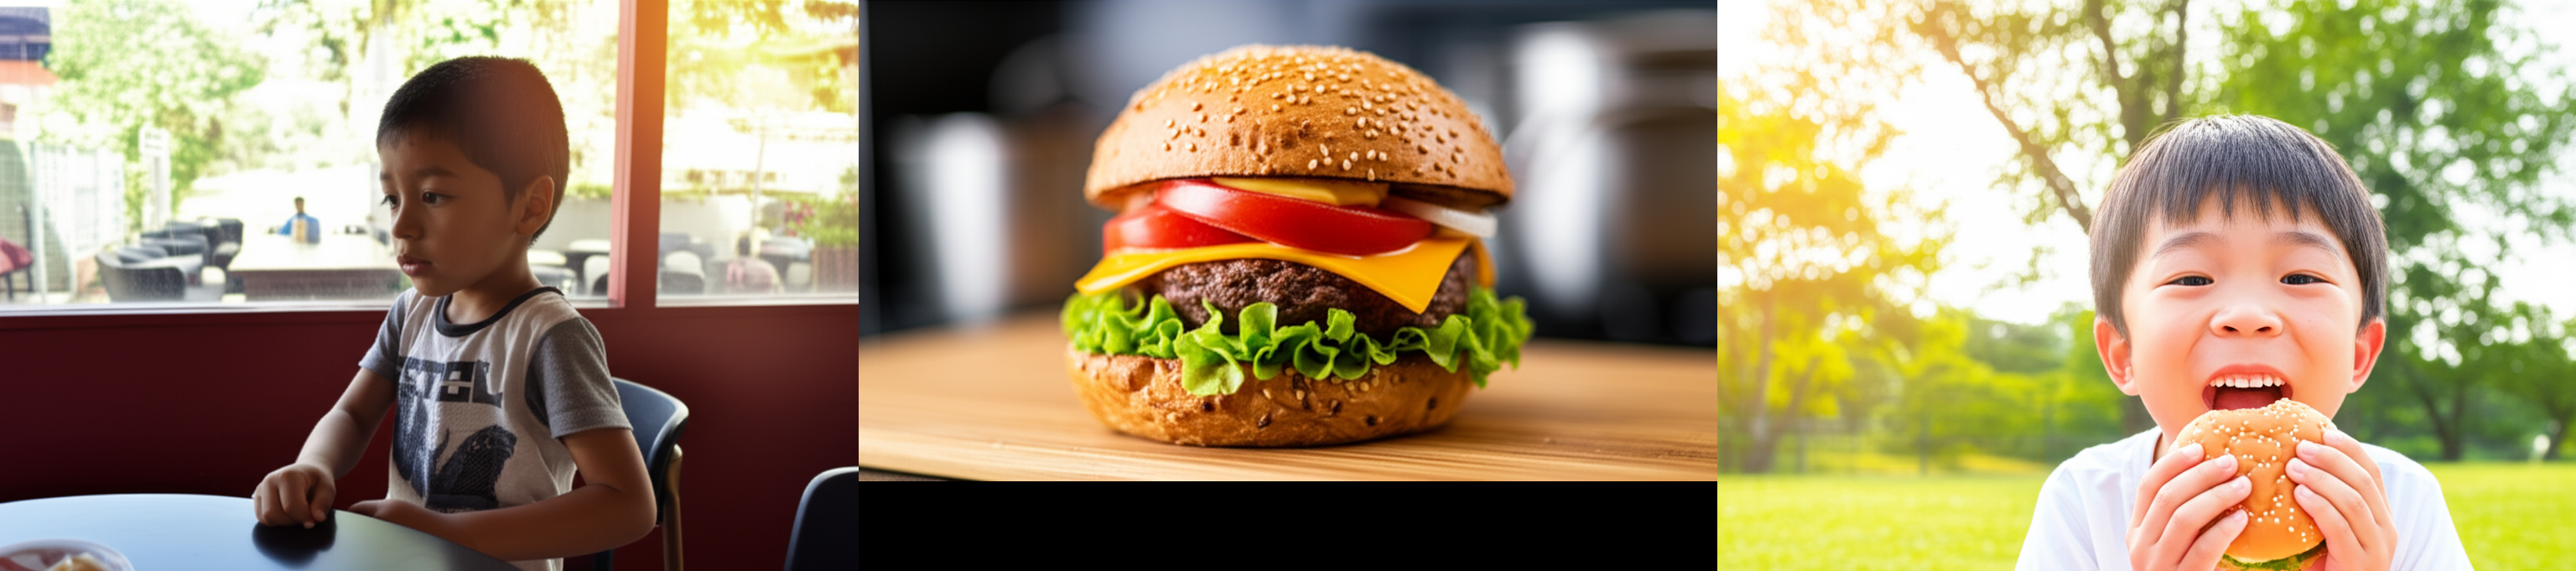

In [17]:
from PIL import Image
import requests

def image_grid(imgs, cols):
    rows = (len(imgs) + cols - 1) // cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

boy_image = Image.open("Data/kids/1 (16).png")
burger_image = Image.open("Data/burgers/1 (9).png")
combo_image = Image.open("Data/kid-eat-burger/1 (4).png")

images = [boy_image, burger_image, combo_image]

# for url in image_urls:
#     images.append(Image.open(requests.get(url, stream=True).raw))


grid = image_grid(images, cols=3)
display(grid)

In [18]:
classes = ['a kid', 'a burger', 'a kid eating a burger', 'adventure trip on the road']
inputs = processor(text=classes, images=images, return_tensors="pt", padding=True, do_convert_rgb=False)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

l = probs.tolist()



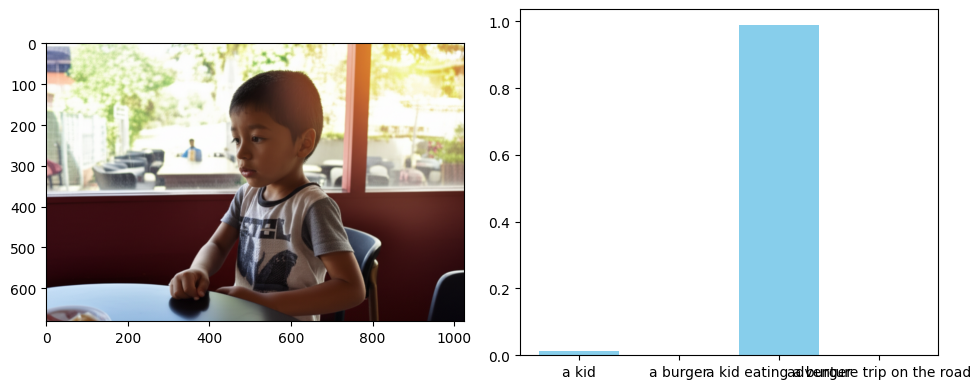

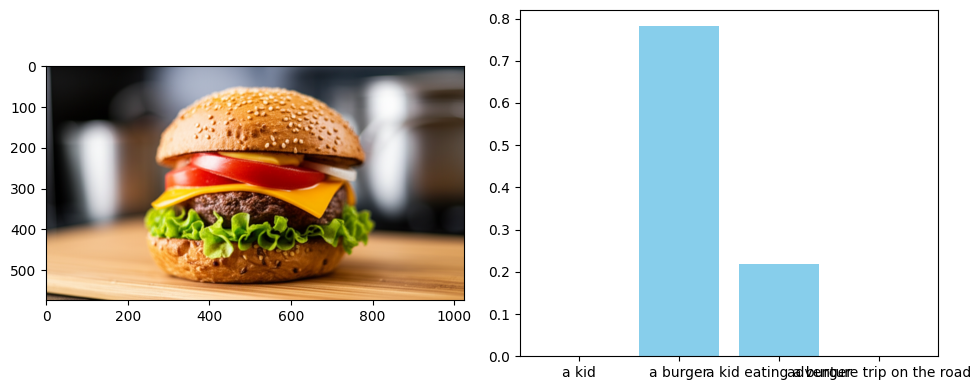

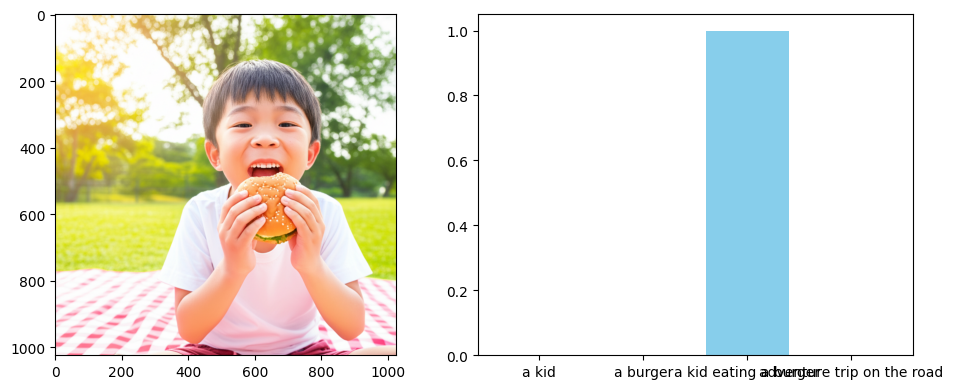

In [19]:
import matplotlib.pyplot as plt
import numpy as np
labels = classes
for i, imss in enumerate(images):
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].imshow(imss)
    axes[1].bar(labels,l[i],color='skyblue')
    plt.tight_layout()

plt.show()

In [20]:
from transformers import CLIPProcessor, CLIPModel

model2 = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", cache_dir = "./clip_cache")
processor2 = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", cache_dir = "./clip_cache")

In [21]:
classes = ['a kid', 'a burger', 'a kid eating a burger', 'adventure trip on the road']
inputs = processor2(text=classes, images=images, return_tensors="pt", padding=True, do_convert_rgb=False)

outputs = model2(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

l2 = probs.tolist()

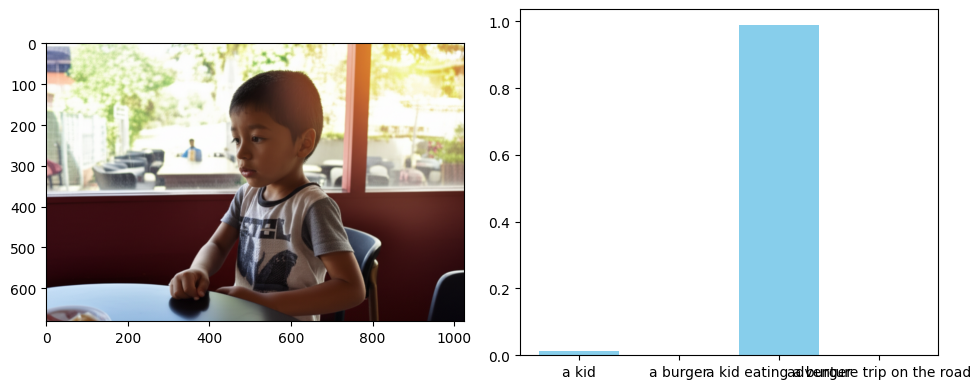

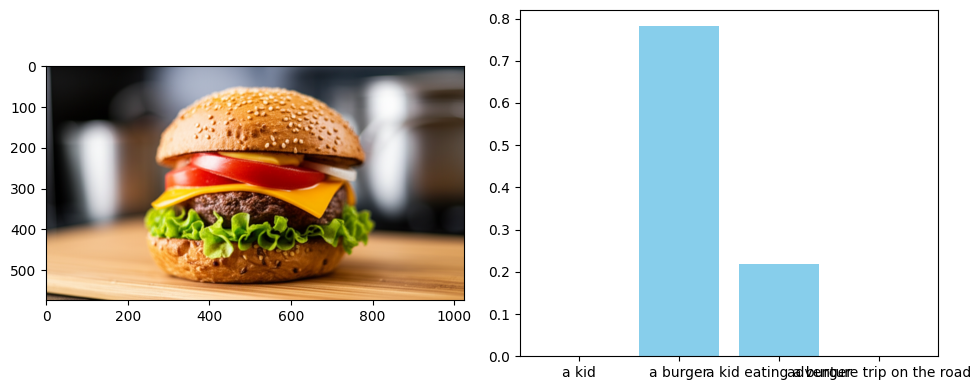

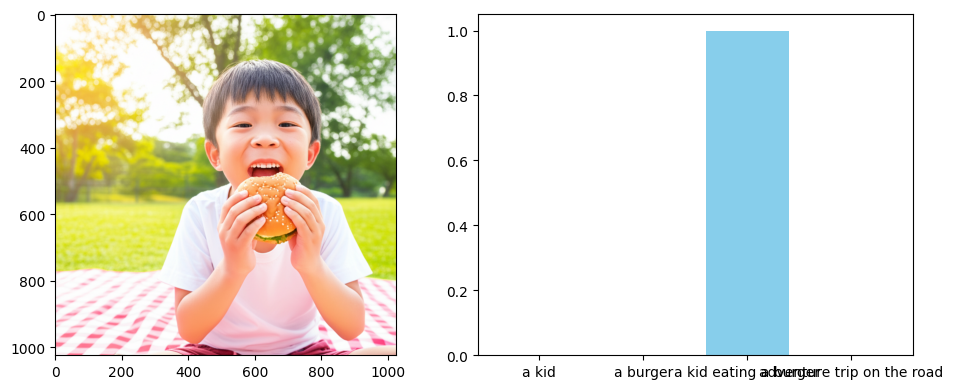

In [22]:
import matplotlib.pyplot as plt
import numpy as np
labels = classes
for i, imss in enumerate(images):
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].imshow(imss)
    axes[1].bar(labels,l2[i],color='skyblue')
    plt.tight_layout()

plt.show()

In [23]:
l, l2

([[0.01178519893437624,
   0.00044692656956613064,
   0.987663209438324,
   0.00010471571295056492],
  [3.151991404592991e-05,
   0.7812392711639404,
   0.2187168002128601,
   1.2506587154348381e-05],
  [2.1141300749150105e-05,
   0.00010957261838484555,
   0.9998685121536255,
   7.194113891273446e-07]],
 [[0.01178519893437624,
   0.00044692656956613064,
   0.987663209438324,
   0.00010471571295056492],
  [3.151991404592991e-05,
   0.7812392711639404,
   0.2187168002128601,
   1.2506587154348381e-05],
  [2.1141300749150105e-05,
   0.00010957261838484555,
   0.9998685121536255,
   7.194113891273446e-07]])